In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.optim as optim
import torch.distributions as D
import torch.nn.functional as F

from torch.utils.data import DataLoader
from models import LeNet, StoLeNet
from utils import compute_accuracy, compute_ece_loss

In [2]:

# setup device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.deterministic = True

In [3]:
# prepare data
data_dir = "./data"
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))
])

trainset = torchvision.datasets.FashionMNIST(root=data_dir, train=True, transform=transform, download=False)
testset = torchvision.datasets.FashionMNIST(root=data_dir, train=False, transform=transform, download=False)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=64, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal',
                'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [4]:
# ===================================================== #
# ========= train a deterministic model =============== #
# ===================================================== #

num_epochs = 10
base_model = LeNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(base_model.parameters(), lr=0.001, momentum=0.9)

loss_list, acc_list, ece_list = [[] for _ in range(3)]
for epoch in range(num_epochs):
    base_model.train()
    batch_loss = []
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = base_model(img)
        loss = criterion(pred, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        
    avg_loss = sum(batch_loss)/len(batch_loss)
    base_acc = compute_accuracy(base_model, testloader, device=device)
    base_ece = compute_ece_loss(base_model, testloader, device=device)
    print("Base Model Epoch {} Avg Loss {} Acc {} base ECE {}".format(epoch, avg_loss, base_acc, base_ece))
    loss_list.append(avg_loss)
    acc_list.append(base_acc)
    ece_list.append(base_ece)

Base Model Epoch 0 Avg Loss 1.2981428761641185 Acc 0.7496 base ECE 0.018470143899321556
Base Model Epoch 1 Avg Loss 0.5633656382322312 Acc 0.8078 base ECE 0.02489040419459343
Base Model Epoch 2 Avg Loss 0.4808783755024274 Acc 0.8213 base ECE 0.008533011190593243
Base Model Epoch 3 Avg Loss 0.4315191090861956 Acc 0.8465 base ECE 0.007372028194367886
Base Model Epoch 4 Avg Loss 0.3972207599918048 Acc 0.8588 base ECE 0.012379495427012444
Base Model Epoch 5 Avg Loss 0.37016162290970483 Acc 0.8627 base ECE 0.009830226190388203
Base Model Epoch 6 Avg Loss 0.35316047245264054 Acc 0.8639 base ECE 0.011099474504590034
Base Model Epoch 7 Avg Loss 0.33574588559865953 Acc 0.8722 base ECE 0.008452760055661201
Base Model Epoch 8 Avg Loss 0.32311446284850437 Acc 0.8699 base ECE 0.009196480736136436
Base Model Epoch 9 Avg Loss 0.3119248220920563 Acc 0.8782 base ECE 0.006135201547294855


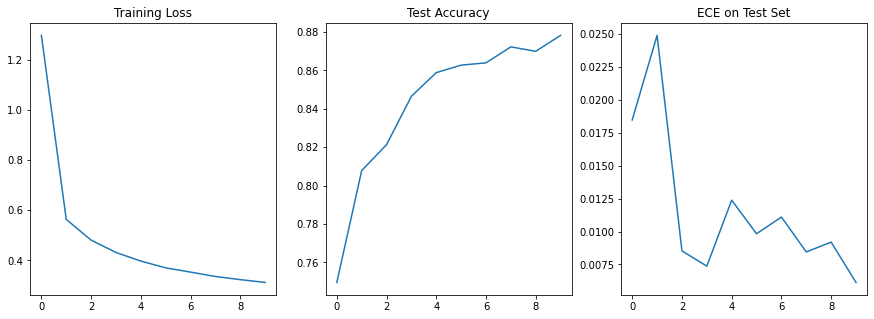

In [5]:
plt.figure(figsize=(15, 5))
plt.subplot(1,3,1)
plt.plot(loss_list)
plt.title("Training Loss")
plt.subplot(1,3,2)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(1,3,3)
plt.plot(ece_list)
plt.title("ECE on Test Set")
plt.show()

In [4]:
# ===================================================== #
# == migrate from base model, finetune and train flow = #
# ===================================================== #

sto_model_cfg = [
            ("normal", {"loc":1.0, "scale":0.5},  # the name of base distribution and parameters for that distribution
                [("affine", 1, {"learnable":True}), # the first stack of flows (type, depth, params)
                ("planar2d", 6, {"init_sigma":0.01})] # the second stack of flows (type, depth, params)
            ),
            (
                "normal", {"loc":1.0, "scale":0.5}, 
                [("affine", 1), 
                 ("planar", 6)]
            )
            ]
sto_model = StoLeNet(sto_cfg=sto_model_cfg).to(device)
sto_model.migrate_from_det_model(base_model)
det_params, sto_params = sto_model.det_and_sto_params()
optimizer = optim.Adam([
                {'params': det_params, 'lr': 1e-4},
                {'params': sto_params, 'lr': 1e-3}
            ])

In [8]:
num_epochs = 10
loss_list, ll_list, kl_list, acc_list, ece_list = [[] for _ in range(5)]
for epoch in range(num_epochs):
    sto_model.train()
    batch_loss, batch_ll, batch_kl = [[] for _ in range(3)]
    for img, label in trainloader:
        img, label = img.to(device), label.to(device)
        pred = sto_model(img)
        log_likelihood, kl = sto_model.calc_loss(pred, label)
        loss = -log_likelihood + kl / len(trainloader.dataset)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_loss.append(loss.item())
        batch_ll.append(log_likelihood.item()) 
        batch_kl.append(kl.item()/ len(trainloader.dataset))
    avg = lambda l: sum(l)/len(l)
    avg_loss, avg_ll, avg_kl = avg(batch_loss), avg(batch_ll), avg(batch_kl)
    sto_acc = compute_accuracy(sto_model, testloader)
    sto_ece = compute_ece_loss(sto_model, testloader)
    print("Sto Model Epoch {} Avg Loss {} Likelihood {} KL {} Acc {} base ECE {}".format(
                        epoch, avg_loss, avg_ll, avg_kl,sto_acc, sto_ece))
    loss_list.append(avg_loss)
    ll_list.append(avg_ll)
    kl_list.append(avg_kl)
    acc_list.append(sto_acc)
    ece_list.append(sto_ece)

Sto Model Epoch 0 Avg Loss 0.48969735270341236 Likelihood -0.4898872594356537 KL -11.394426950073242 Acc 0.8417 base ECE 0.014797068201005459
Sto Model Epoch 1 Avg Loss 0.40587076974312464 Likelihood -0.4060843905131022 KL -12.817233733622233 Acc 0.8482 base ECE 0.012360714375972748
Sto Model Epoch 2 Avg Loss 0.3676551173518101 Likelihood -0.3678857354521751 KL -13.837095395914714 Acc 0.8619 base ECE 0.010496129281818867
Sto Model Epoch 3 Avg Loss 0.3384376521408558 Likelihood -0.33868615895907084 KL -14.910417460632324 Acc 0.8665 base ECE 0.01616501808166504
Sto Model Epoch 4 Avg Loss 0.3187006612956524 Likelihood -0.31896359964211785 KL -15.776316886901855 Acc 0.8663 base ECE 0.014645892195403576
Sto Model Epoch 5 Avg Loss 0.3022997638950745 Likelihood -0.3025764819264412 KL -16.603082111612956 Acc 0.8783 base ECE 0.01660630665719509
Sto Model Epoch 6 Avg Loss 0.2854824803551038 Likelihood -0.2858058885018031 KL -19.404498688761393 Acc 0.8772 base ECE 0.017407534644007683
Sto Model E

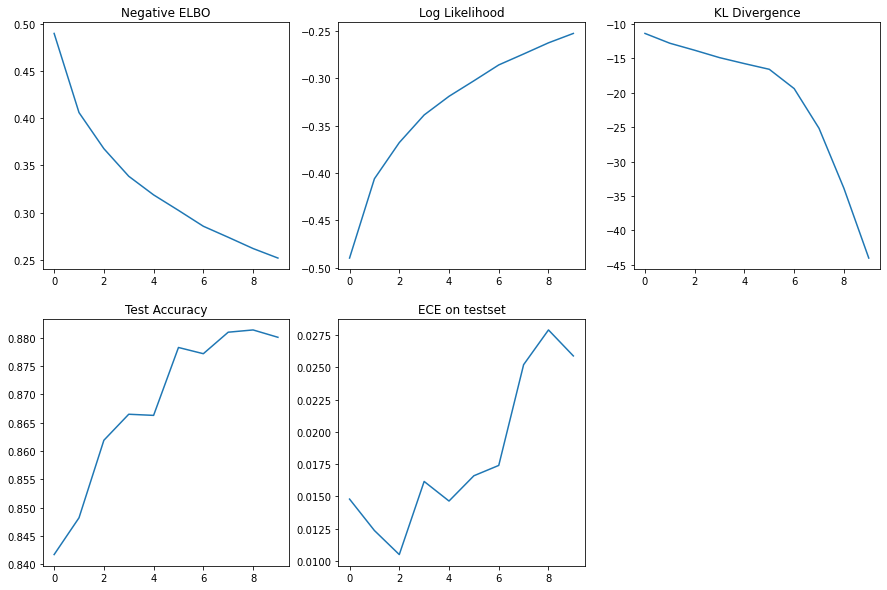

In [9]:
plt.figure(figsize=(15, 10))
plt.subplot(2,3,1)
plt.plot(loss_list)
plt.title("Negative ELBO")
plt.subplot(2,3,2)
plt.plot(ll_list)
plt.title("Log Likelihood")
plt.subplot(2,3,3)
plt.plot(kl_list)
plt.title("KL Divergence")
plt.subplot(2,3,4)
plt.plot(acc_list)
plt.title("Test Accuracy")
plt.subplot(2,3,5)
plt.plot(ece_list)
plt.title("ECE on testset")
plt.show()